In [5]:
import numpy as np 
import pandas as pd
import allel
import malariagen_data
%matplotlib inline
import probe
import locusPocus
%run hapclust.py

In [6]:
def lewontin_d_prime(h, i, j, a=1, b=1):
    h = allel.HaplotypeArray(h)
    n_a = n_b = 0  # allele counts
    n_ab = 0  # haplotype counts
    n = 0  # allele number (i.e., number of calls)
    for k in range(h.n_haplotypes): # iterate over haplotypes, counting alleles and haplotypes
        allele_ik = h[i, k]
        allele_jk = h[j, k]
        if allele_ik < 0 or allele_jk < 0:    continue
        if allele_ik == a:                    n_a += 1
        if allele_jk == b:                    n_b += 1
        if allele_ik == a and allele_jk == b: n_ab += 1
        n += 1
    if n == 0 or n_a == 0 or n_b == 0 or n == n_a or n == n_b:
        return None # bail out if no data or either allele is absent or fixed
    # compute coefficient of linkage disequilibrium * n**2
    D_ab = (n * n_ab) - (n_a * n_b)
    # compute normalisation coefficient * n**2
    if D_ab >= 0: D_max = min(n_a * (n - n_b), (n - n_a) * n_b)
    else:         D_max = min(n_a * n_b, (n - n_a) * (n - n_b))
    # compute D prime
    D_prime = D_ab / D_max
    return D_prime

def lewontin_d_prime_varloop(h):
    n = len(h)
    ld = np.zeros((n, n), dtype='f8')
    for i,_ in enumerate(h):
        for j,_ in enumerate(h):
            if i != j:
                ld[i, j] = lewontin_d_prime(h=h,i=i,j=j)
    return(ld)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")
    
def clustersToFrequencies(transcript, cluster_spans, geno, pos, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
        
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False, metaquery=None):
    
    probe.log("Remapping haplotype alleles to match snp effect data...")   
    haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    haplos, pos = remap_haplo_alleles(haplos=haplos, haplo_pos=pos, transcript=transcript, metaquery=metaquery)
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    plt.show()
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(transcript, sample_sets=sample_set, analysis='gamb_colu_arab')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set, metaquery=metaquery)  
    return(df_af, coh, leaves)

def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            ac_coh = gt_coh.count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)
    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    )
    pos_bool = np.isin(df_effects['position'], pos)
    df_effects = df_effects[pos_bool]
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)
    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

def remap_haplo_alleles(haplos, haplo_pos, transcript, metaquery):
    """
    Because haplotypes are coded 0,1, but genotypes 0-3, 1s in the haplotype may refer to different ALTs in the genotype array. This
    causes a problem when using ag3.snp_effects() to fit alleles to their aa change, therefore, we need to recode alleles back to the correct
    ALT
    """
    # Load genotype data - needed to find correct ALT for each SNP
    geno = allel.GenotypeDaskArray(ag3.snp_genotypes(region=transcript, sample_sets=cohorts))
    meta = ag3.sample_metadata(cohorts)
    if metaquery != None:
        meta = meta.query(metaquery)
    geno = geno.take(meta.index.to_list(), axis=1)
    geno_pos = allel.SortedIndex(ag3.snp_sites(region=transcript, field='POS').compute())
    
    # find intersection between haplotype positions and genotypes 
    geno_mask, hap_mask = geno_pos.locate_intersection(haplo_pos)
    geno = geno.compress(geno_mask, axis=0)
    ac = geno.count_alleles().compute()
    
    # remove multiallelics, there shouldnt be any in here?
    multiallele_mask = (ac > 0).sum(axis=1) > 2
    ac = ac[~multiallele_mask]
    # find appropriate allele
    mappings = np.argmax(ac[:,1:], axis=1) + 1
    # make mapping array for scikit-allel
    zeros = np.zeros(len(mappings))
    mapping = np.vstack([zeros, mappings]).T
    
    # Remap!
    haplos = haplos[~multiallele_mask].map_alleles(mapping)
    haplo_pos  = haplo_pos[~multiallele_mask]
       
    return(haplos, haplo_pos)

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

def load_metahaps(cohorts, names, metaquery = None):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta.loc[:, 'sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    if metaquery != None: 
        query_bool = meta.eval(metaquery)
        meta = meta.query(metaquery)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    if metaquery == None:
        return(metahaps, np.repeat(True, meta.shape[0]))
    else:
        return(metahaps, query_bool)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")
    
def haplotypes_to_aa_pandas(haps_xarray, snpdf, myquery="max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'", reverse=False, metaquery= None):
    #Subset the data to all aa changes above 5% frequency
    aa_snps = snpdf.query(myquery)['position'].to_list()
    pos_bool = allel.SortedIndex(haps_xarray['variant_position'].values).locate_intersection(aa_snps)[0]
    print(f"There are {len(aa_snps)} amino acid changes with {myquery}")
    
    metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
    haps2 = allel.GenotypeArray(haps_xarray['call_genotype'].isel(variants=pos_bool, samples=query_bool).compute()).to_haplotypes()
    
    haps_df = pd.DataFrame(haps2)
    haps_df.loc[:, 'aa_change'] = snpdf.query(myquery).reset_index()['aa_change']
    haps_df = haps_df.set_index('aa_change')
    haps_df = haps_df.iloc[::-1] if reverse == True else haps_df # only if reverse strand like AGAP006227
    return(haps_df) # can only run once!

def rename_duplicates( old ):
    seen = {}
    for x in old:
        if x in seen:
            seen[x] += 1
            yield "%s_%d" % (x, seen[x])
        else:
            seen[x] = 0
            yield "%s_%d" % (x, seen[x])

## LD

Lewontins D'

In [3]:
contig= '2L'

coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28520000-28580000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

cohorts = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [32]:
metaquery = None

snps = ag3.haplotypes(contig, sample_sets=cohorts, analysis='gamb_colu_arab')
names = snps['sample_id'].values
pos = allel.SortedIndex(snps['variant_position'])
gene_bool = pos.locate_ranges([coeae1f_start], [coeae2f_end])
metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
snps = snps.isel(variants=gene_bool, samples=query_bool)
haps = allel.GenotypeArray(snps['call_genotype'].compute()).to_haplotypes()

assert metahaps.shape[0] == haps.shape[1], "Wrong shape Dude!!"

Subset to AA variants only.

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-TZ', '1244-VO-GH-YAWSON-VMF00149', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 2431
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


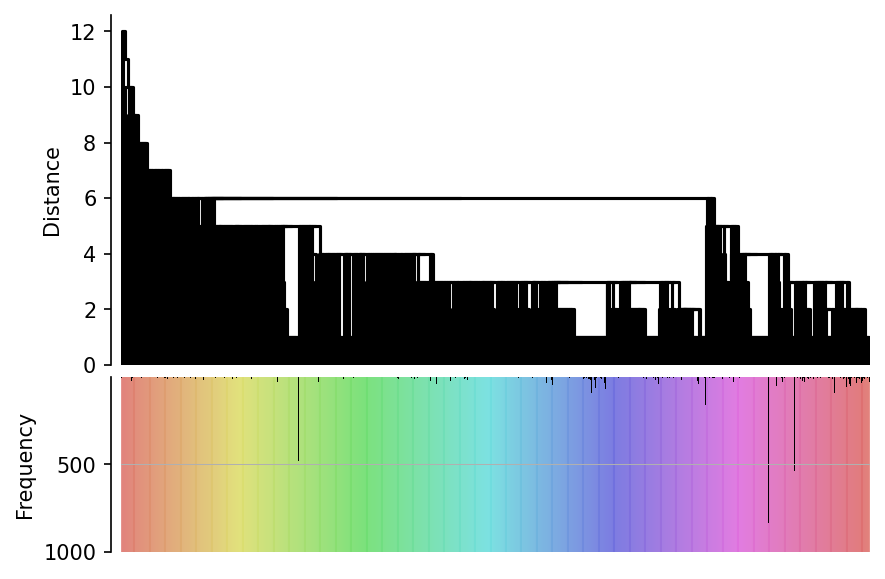

Finding allele frequencies from cluster indices
There are 8 clusters with [478, 89, 71, 160, 832, 539, 92, 2601]
['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-TZ', '1244-VO-GH-YAWSON-VMF00149', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 2431
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


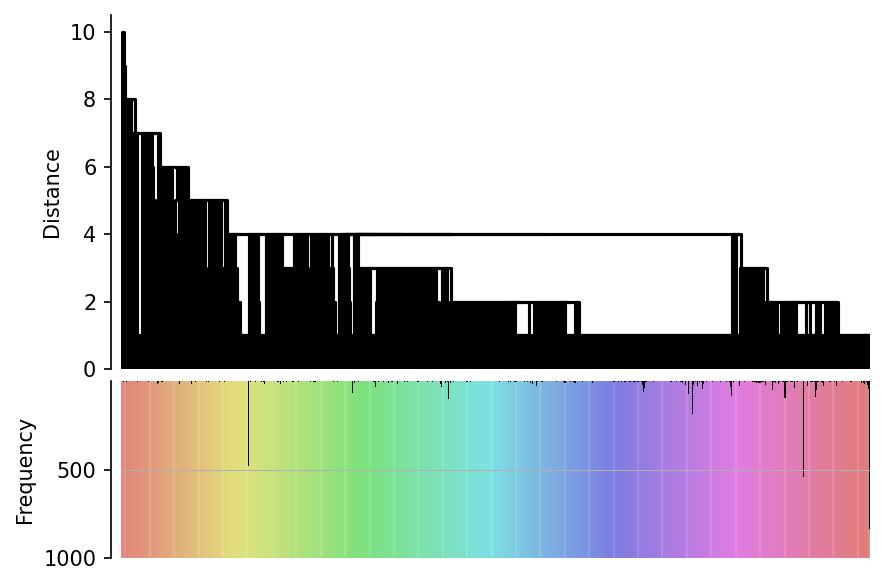

Finding allele frequencies from cluster indices
There are 10 clusters with [482, 103, 73, 187, 84, 94, 540, 90, 838, 2371]


In [33]:
snpdf_227, coho, leav = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=1, t=0, min_cohort_size=70, metaquery=None)
snpdf_228, coho2, leav = phase3cluster(cohorts, "AGAP006228-RA", contig, cut=1, t=0, min_cohort_size=70, metaquery=None)

In [34]:
eff = pd.concat([snpdf_227, snpdf_228]).query("max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'")
aapos = eff['position'].unique()

aa_mask = pos[gene_bool].locate_intersection(aapos)[0]

haps = haps.compress(aa_mask, axis=0)

In [10]:
haps_df, nonsyn = locusPocus.load_multiallelic_haplotypes("../../results/phasing/coeae1f.phasedMulti.vcf",
                                       sample_sets=cohorts, contig='2L', start=coeae1f_start, end=coeae1f_end)

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/allel/io/vcf_read.py:1743: UserWarning: invalid FORMAT header: "##FORMAT=<ID=GT,Number=1,Type=String,Description='Genotype'>\n"
  warnings.warn('invalid FORMAT header: %r' % header)
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: "##INFO=<ID=NUMALT,Number=1,Type=Integer,Description='Number of alternative alleles'>\n"
  warnings.warn('invalid INFO header: %r' % header)
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: "##INFO=<ID=AVGPOST,Number=1,Type=Float,Description='Average posterior probability from MVNcall'>\n"
  warnings.warn('invalid INFO header: %r' % header)
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/allel/io/vcf_read.py:1743: UserWarning: invalid FORMAT header: "##FORMAT=<ID=PL,Number=.,Type=Integer,Description='Phred-scaled Genotype Likelihoods'>\n"
  warnings.warn('invalid FORMAT 

Genotypes loaded
only two alleles = 28545862
only two alleles = 28545945
only two alleles = 28546024
only two alleles = 28546029
only two alleles = 28546185
only two alleles = 28546335
only two alleles = 28546340
only two alleles = 28546376
only two alleles = 28546460
only two alleles = 28546587
only two alleles = 28546588
only two alleles = 28546589
only two alleles = 28546634
only two alleles = 28546656
only two alleles = 28546660
only two alleles = 28546810
only two alleles = 28547166
only two alleles = 28547522
only two alleles = 28547729
only two alleles = 28547744
only two alleles = 28547759
only two alleles = 28547780
loading df_effects for region
remapping biallelic haplotypes


Load sample metadata:   0%|          | 0/12 [00:00<?, ?it/s]

filtering to seg sites
intersecting with df_effects
extracting aa change info for each SNP


In [15]:
haps = allel.HaplotypeArray(haps_df[nonsyn].values)
seg = haps.count_alleles().is_segregating()
haps = haps.compress(seg, axis=0)

In [20]:
# lewontin D' linkage disequilibrium
print("LD Lewontin D'...")
fig = plt.figure(figsize=(10,10))
ld_lewdp = lewontin_d_prime_varloop(h=allel.HaplotypeArray(haps_df[nonsyn].values))     
np.fill_diagonal(ld_lewdp,np.nan)
ax=sns.heatmap(ld_lewdp,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),linewidths=0.8,linecolor="white",annot=True)
ax.set_xticklabels(haps_df.index, rotation=45)
ax.set_yticklabels(haps_df.index, rotation=45)

#ax.set_title("Lewontin $D'$ %s" % l_nom)
#pdf.savefig(fig,bbox_inches='tight')
#pdf.close()


LD Lewontin D'...


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [51]:
sw = list(coho.keys())[0]
idxs = list(coho.values()

'n=478 | E477V'

### IT doesnt make sense to do for each sweep as there are no segregating variants!!

## for coh, idxs in zip(list(coho.keys())[0], [list(coho.values())[0]]):           #coho.items():

    h = haps.take(idxs, axis=1)
    # lewontin D' linkage disequilibrium
    print("LD Lewontin D'...")
    fig = plt.figure(figsize=(10,10))
    ld_lewdp = lewontin_d_prime_varloop(h=h)     
    np.fill_diagonal(ld_lewdp,np.nan)
    ax=sns.heatmap(ld_lewdp,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),linewidths=0.8,linecolor="white",annot=True)
    ax.set_xticklabels(eff['aa_change'], rotation=45)
    ax.set_yticklabels(eff['aa_change'], rotation=45)

### Networks

In [ ]:
palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((0.9, 0.9, 0.9))
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

max_dist = 3       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
max_alle = 1       # indirect variant breaks
net_meth = "msn"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
min_fq_h = 0.1   # min freq of the haplotype cluster, below that the component will be excluded from plots
min_fc_h = int(min_fq_h*haps.shape[1])

labels = np.repeat("", haps.shape[0]).astype("object")

labels[aa_mask] = eff['aa_change'].to_numpy()

import warnings
warnings.filterwarnings('ignore')

loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=haps,
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=min_fc_h,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=None, variant_labels=labels,
    return_components=True,show_singletons=True)

num_components = loc_components.shape[0]

warnings.filterwarnings('ignore')

loc_graph